# ISEL - Aprendizagem Automática(AA)
## Semestre de Inverno 2025/26
# <br>
###  <center> Trabalho Prático 1 </center>
# </br>

Trabalho realizado por:
* <b>Ruben Zhang, número 51388 </b>
* <b>Sofia Salgado, número 51694 </b>
* <b>Lucas Filipe , número 51793 </b>


<b> Turma 51D - Docente: Gonçalo Marques </b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import (confusion_matrix, roc_curve, precision_recall_curve, precision_score, recall_score,
                             accuracy_score, f1_score, roc_auc_score, ConfusionMatrixDisplay)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

Objetivos:
1. Obter e ler a informação do ficheiro pickle
2. Normalizar os valores obtidos
3. Verificar a vantagem da normalização dos dados
4. Escolher dois classificadores binarios
5. Treinar os classificadores
6. Testar os classificadores
7. Avaliar os classificadores com base em métricas, calibando caso se verifique necessário
8. Realizar um estudo comparativo dos desempenho dos diferentes classificadores

In [2]:
with open("pimaDiabetes.p", "rb") as f:
    data = pickle.load(f)

X = data.data  # Matriz de features, ou seja os 8 atributos médicos
Y = data.target  # Índices das classes, ou seja, o resultado esperado(saida) se tem diabetes(1) ou não(0), que se prenche
Yn = Y[np.newaxis, :]
XT = X.T


In [3]:


def Grafico_IntervaloValores_Features():
    feature_names = ["Gravidezes", "Glicose", "Pressão Arterial", "Espessura Dobra", "Insulina", "BMI", "Pedigree",
                     "Idade"]
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.grid()
        plt.hist(X[:, i], bins=20, color='skyblue', edgecolor='black')
        plt.title(feature_names[i])
    plt.tight_layout()
    plt.show()


def Normaliza_Dados():
    #Normalização dos dados de forma automatica
    scaler = StandardScaler()
    Xn = scaler.fit_transform(X)
    # print("Médias (devem ser 0):", np.mean(Xn, axis=1))
    # print("Desvios padrão (devem ser 1):", np.std(Xn, axis=1))
    return Xn


def SepararDadosTreinoTeste(Xn, y, TesteSize, RandomState):
    XTrain, XTest, YTrain, YTest = train_test_split(Xn, y, test_size=TesteSize, random_state=RandomState, stratify=y)
    return XTrain, XTest, YTrain, YTest


def TreinarRandomForest(Xn, y):
    print("--" * 20)
    print("Classificador RandomForest")

    XTrain, XTest, YTrain, YTest = SepararDadosTreinoTeste(Xn, y, 0.3, 42)
    RF = RandomForestClassifier(random_state=42).fit(XTrain, YTrain)
    YPredict = RF.predict(XTest)

    print("Acertos no teste:", RF.score(XTest, YTest) * 100, "%")

    YProb = RF.predict_proba(XTest)[:, 1]  # Probabilidades da classe positiva
    AvaliarClassificador(RF, YTest, YPredict, YProb)

    ModCal = CalibrarModelo(XTrain, YTrain, RF, 5)
    ModCal.fit(XTrain, YTrain)
    YProb_cal = ModCal.predict_proba(XTest)[:, 1]
    AvaliarClassificador(RF, YTest, YPredict, YProb_cal)


def TreinarLogisticRegression(Xn, y):
    print("--" * 20)
    print("Classificador: LogisticRegression")

    XTrain, XTest, YTrain, YTest = SepararDadosTreinoTeste(Xn, y, 0.3, 42)
    LogReg = LogisticRegression(max_iter=10000).fit(XTrain, YTrain)
    YPredict = LogReg.predict(XTest)

    print("Acertos no teste:", LogReg.score(XTest, YTest) * 100, "%")

    YProb = LogReg.predict_proba(XTest)[:, 1]  # Probabilidades da classe positiva
    AvaliarClassificador(LogReg, YTest, YPredict, YProb)

    ModCal = CalibrarModelo(XTrain, YTrain, LogReg, 5)
    ModCal.fit(XTrain, YTrain)
    YProb_cal = ModCal.predict_proba(XTest)[:, 1]
    AvaliarClassificador(LogReg, YTest, YPredict, YProb_cal)


def TreinarKNNVizinhos(Xn, y):
    print("--" * 20)
    print("Classificador KNNVizinhos")

    XTrain, XTest, YTrain, YTest = SepararDadosTreinoTeste(Xn, y, 0.3, 42)
    KNN = KNeighborsClassifier(n_neighbors=5).fit(XTrain, YTrain)
    accuracy = KNN.score(XTest, YTest) * 100
    YPredict = KNN.predict(XTest)

    print("Acertos no teste:", KNN.score(XTest, YTest) * 100, "%")

    YProb = KNN.predict_proba(XTest)[:, 1]  # Probabilidades da classe positiva
    AvaliarClassificador(KNN, YTest, YPredict, YProb)

    ModCal = CalibrarModelo(XTrain, YTrain, KNN, 5)
    ModCal.fit(XTrain, YTrain)
    YProb_cal = ModCal.predict_proba(XTest)[:, 1]
    AvaliarClassificador(KNN, YTest, YPredict, YProb_cal)


def TreinarSVM(Xn, y):
    print("--" * 20)
    print("Classificador SVM")

    XTrain, XTest, YTrain, YTest = SepararDadosTreinoTeste(Xn, y, 0.3, 42)
    SVM = SVC(probability=True).fit(XTrain, YTrain)  #o prob true adiciona o YProb
    YPredict = SVM.predict(XTest)

    print("Acertos no teste:", SVM.score(XTest, YTest) * 100, "%")

    YProb = SVM.predict_proba(XTest)[:, 1]  # Probabilidades da classe positiva
    AvaliarClassificador(SVM, YTest, YPredict, YProb)

    ModCal = CalibrarModelo(XTrain, YTrain, SVM, 5)
    ModCal.fit(XTrain, YTrain)
    YProb_cal = ModCal.predict_proba(XTest)[:, 1]
    AvaliarClassificador(SVM, YTest, YPredict, YProb_cal)


def AvaliarClassificador(modelo, YTest, YPred, YProb=None, titulo="Desempenho do Classificador"):
    print("\n" + "=" * 60)
    print(f"Avaliação do classificador: {modelo}")

    cm = confusion_matrix(YTest, YPred)
    CM = ConfusionMatrixDisplay(confusion_matrix=cm)
    accuracy = accuracy_score(YTest, YPred)
    precision = precision_score(YTest, YPred)
    recall = recall_score(YTest, YPred)
    f1 = f1_score(YTest, YPred)
    cm = confusion_matrix(YTest, YPred)
    tn, fp, fn, tp = cm.ravel()
    # classreprot = classification_report(YVdd, Ypred)

    specificity = tn / (tn + fp)
    auc = roc_auc_score(YTest, YProb) if YProb is not None else None
    print(f"Acurácia:        {accuracy:.3f}")
    print(f"Precisão:        {precision:.3f}")
    print(f"Recall:          {recall:.3f}")
    print(f"F1-Score:        {f1:.3f}")
    print(f"Especificidade:  {specificity:.3f}")
    print(f"AUC:             {auc:.3f}")

    plt.subplots(1, 2, figsize=(16, 5))

    # Curva Precisão–Recall
    plt.subplot(1, 2, 1)
    precision_vals, recall_vals, _ = precision_recall_curve(YTest, YProb)
    plt.plot(recall_vals, precision_vals, color="darkorange", lw=2)
    plt.title("Curva Precisão–Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precisão")
    plt.grid(True)

    # Curva ROC
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(YTest, YProb)
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.title("Curva ROC")
    plt.xlabel("Falso Positivo (FPR)")
    plt.ylabel("Verdadeiro Positivo (TPR)")
    plt.legend(loc="lower right")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    CM.plot(cmap='Blues')
    # print(cm)


def CalibrarModelo(XTrain, YTrain, modelo, CV=5, metodo='sigmoid'):
    MC = CalibratedClassifierCV(modelo, cv=CV, method=metodo)
    MC.fit(XTrain, YTrain)
    return MC



Forma da matriz de X (768, 8)
Forma da matriz de Y (1, 768)


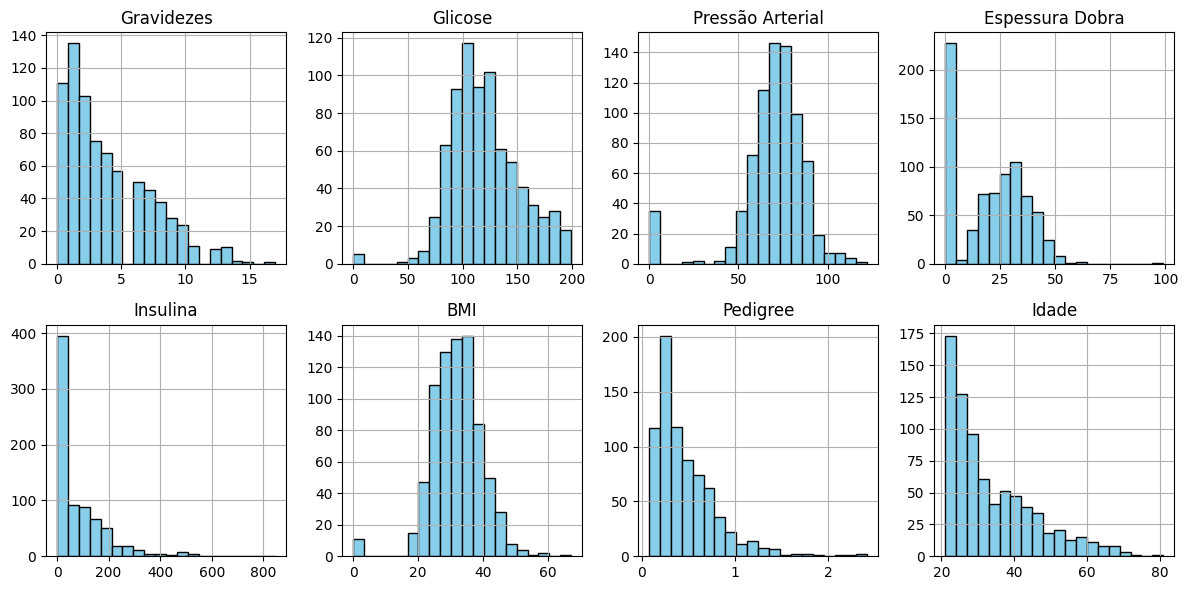

----------------------------------------
Classificador RandomForest
Acertos no teste: 75.32467532467533 %

Avaliação do classificador: RandomForestClassifier(random_state=42)
Acurácia:        0.753
Precisão:        0.688
Recall:          0.543
F1-Score:        0.607
Especificidade:  0.867
AUC:             0.820


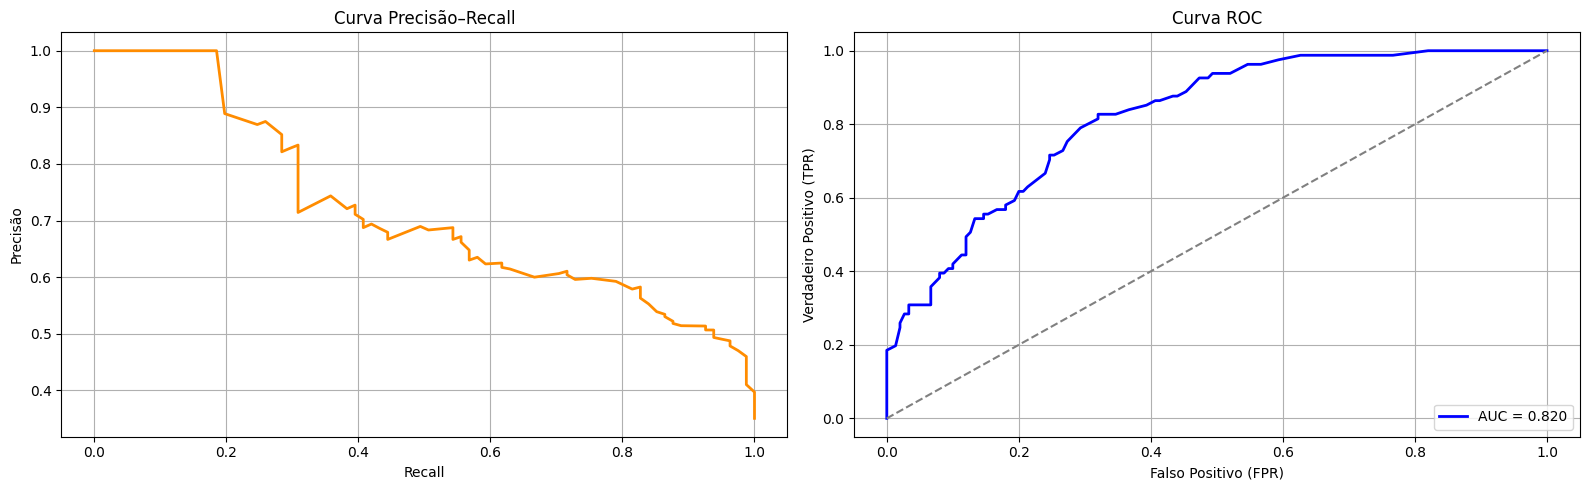


Avaliação do classificador: RandomForestClassifier(random_state=42)
Acurácia:        0.753
Precisão:        0.688
Recall:          0.543
F1-Score:        0.607
Especificidade:  0.867
AUC:             0.826


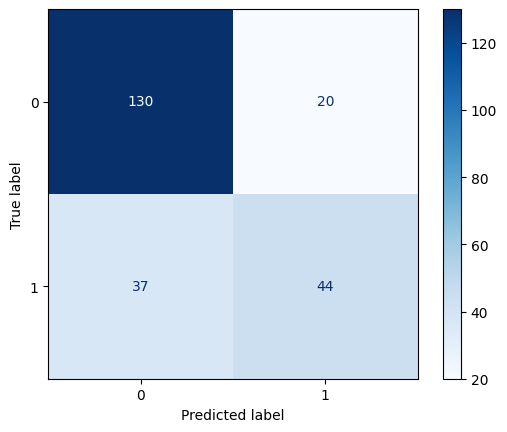

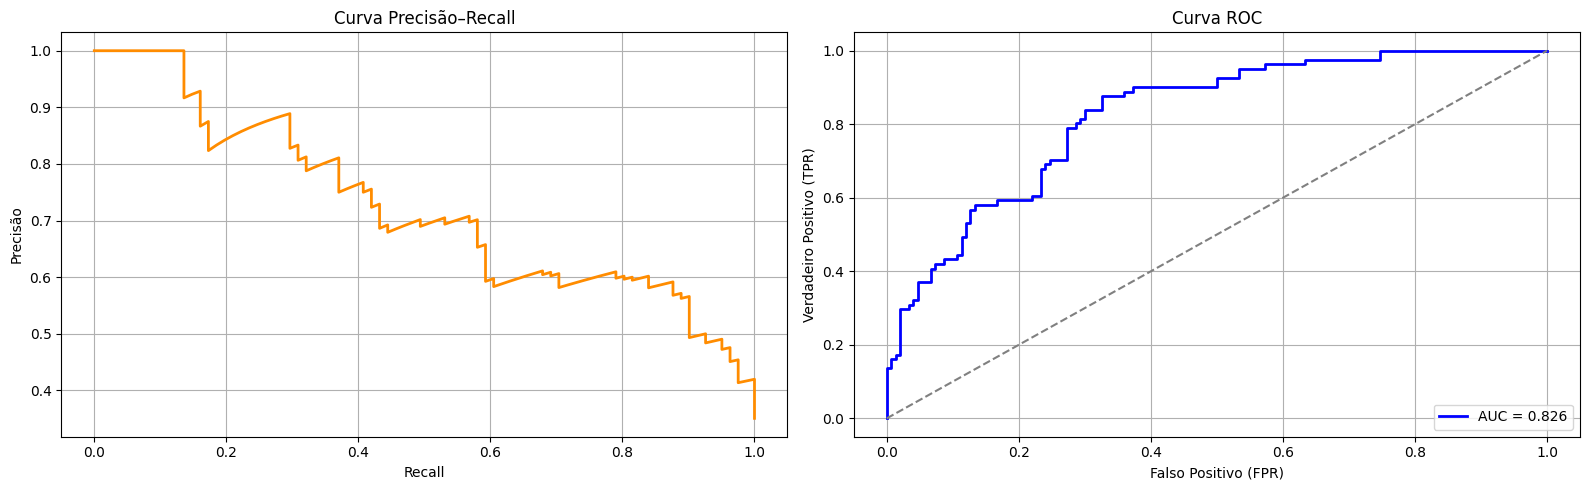

----------------------------------------
Classificador: LogisticRegression
Acertos no teste: 74.45887445887446 %

Avaliação do classificador: LogisticRegression(max_iter=10000)
Acurácia:        0.745
Precisão:        0.677
Recall:          0.519
F1-Score:        0.587
Especificidade:  0.867
AUC:             0.838


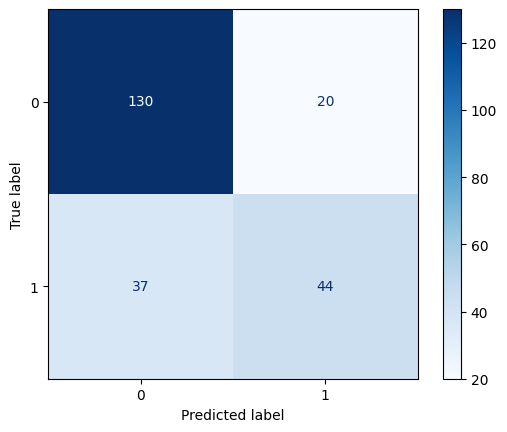

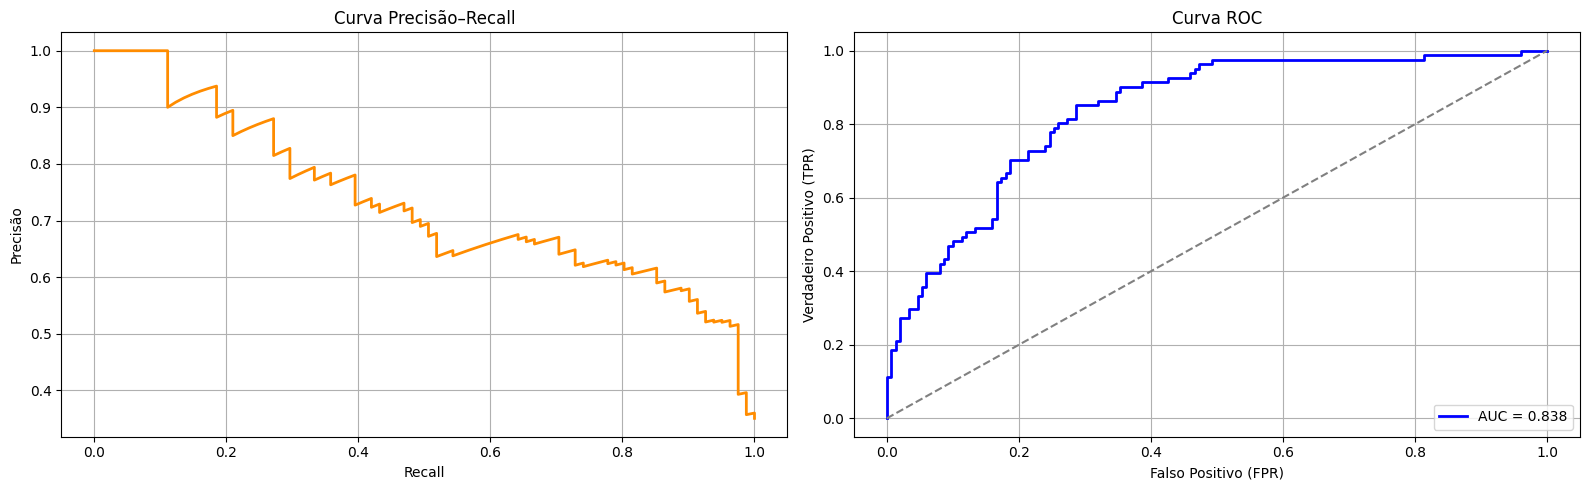


Avaliação do classificador: LogisticRegression(max_iter=10000)
Acurácia:        0.745
Precisão:        0.677
Recall:          0.519
F1-Score:        0.587
Especificidade:  0.867
AUC:             0.837


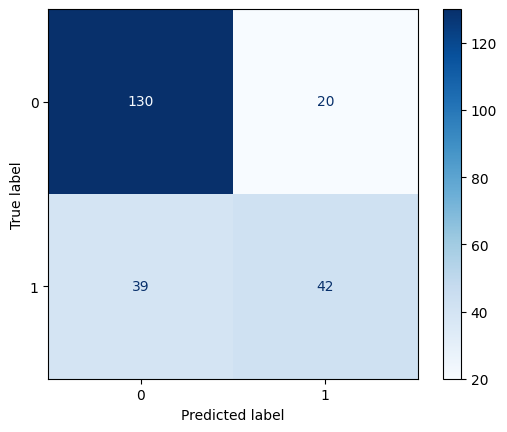

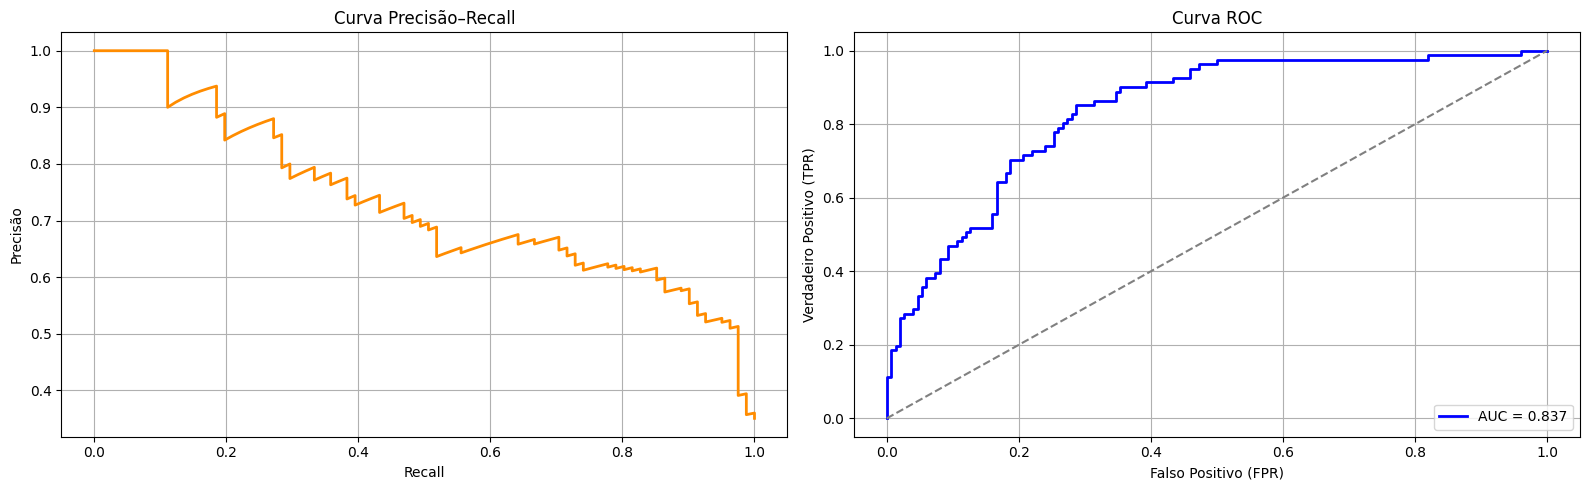

----------------------------------------
Classificador KNNVizinhos
Acertos no teste: 71.42857142857143 %

Avaliação do classificador: KNeighborsClassifier()
Acurácia:        0.714
Precisão:        0.615
Recall:          0.494
F1-Score:        0.548
Especificidade:  0.833
AUC:             0.757


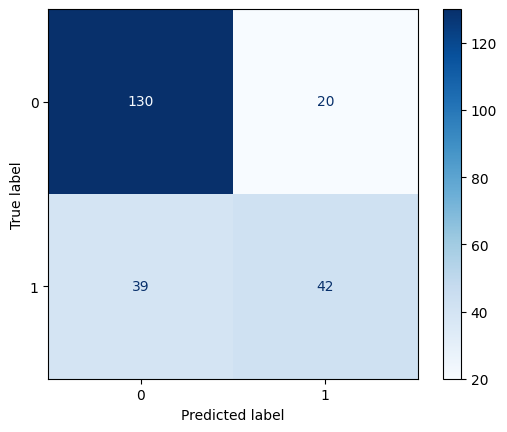

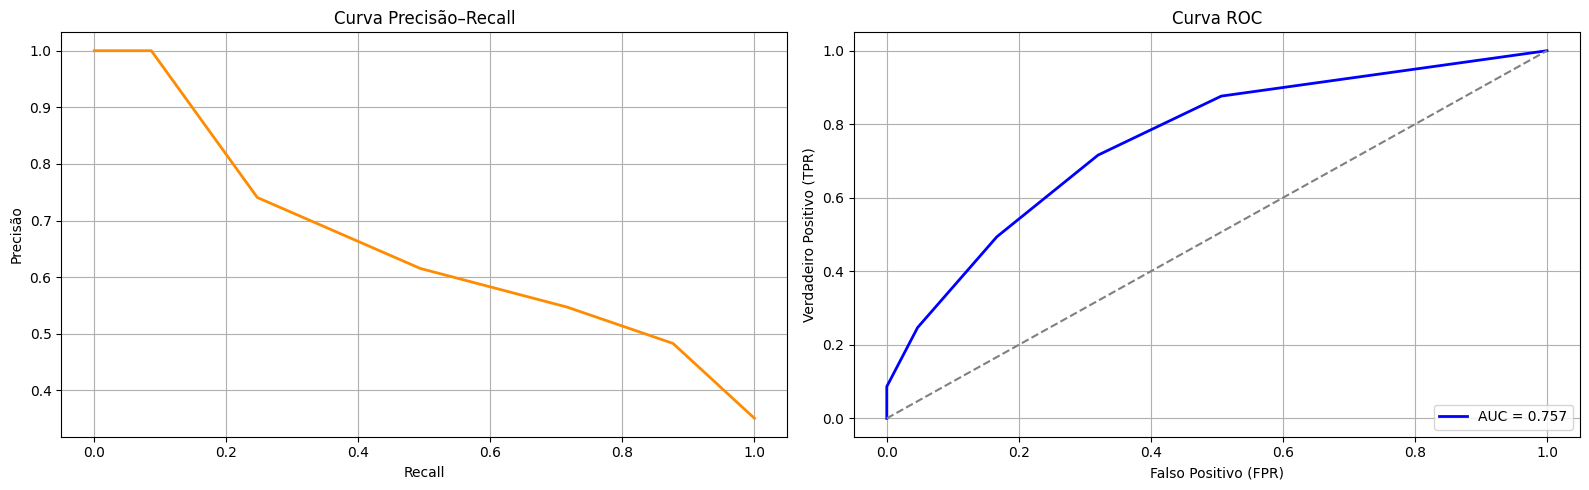


Avaliação do classificador: KNeighborsClassifier()
Acurácia:        0.714
Precisão:        0.615
Recall:          0.494
F1-Score:        0.548
Especificidade:  0.833
AUC:             0.788


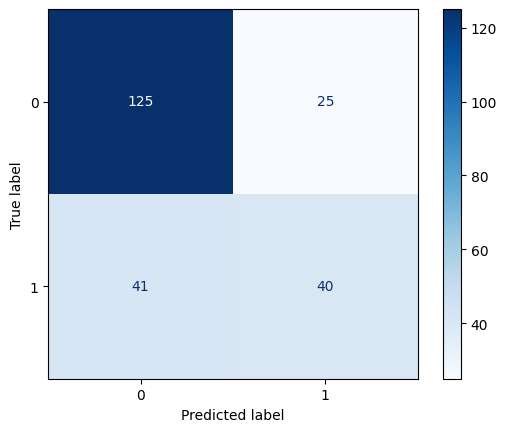

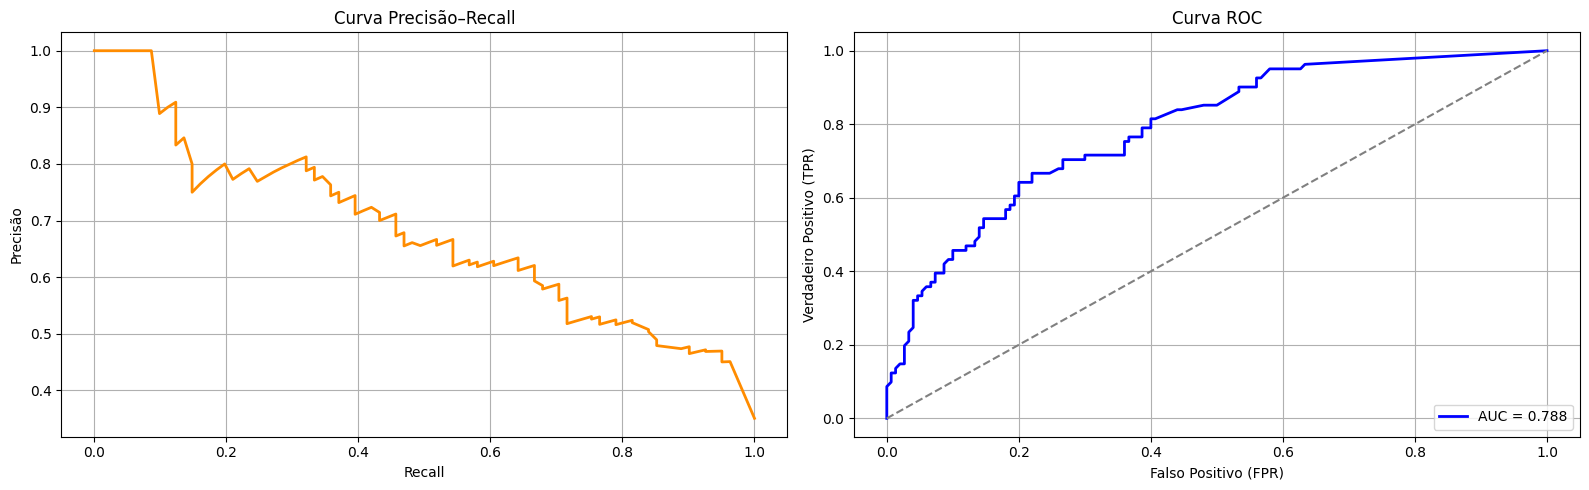

----------------------------------------
Classificador SVM
Acertos no teste: 74.89177489177489 %

Avaliação do classificador: SVC(probability=True)
Acurácia:        0.749
Precisão:        0.677
Recall:          0.543
F1-Score:        0.603
Especificidade:  0.860
AUC:             0.811


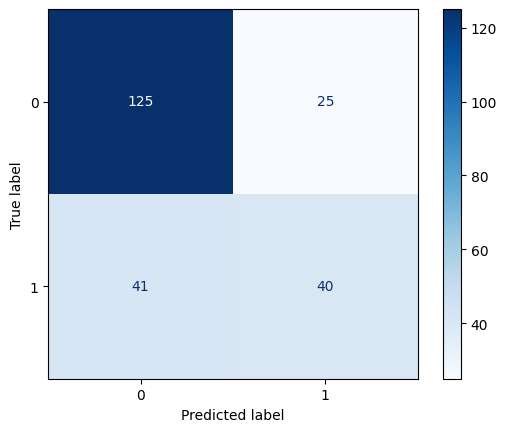

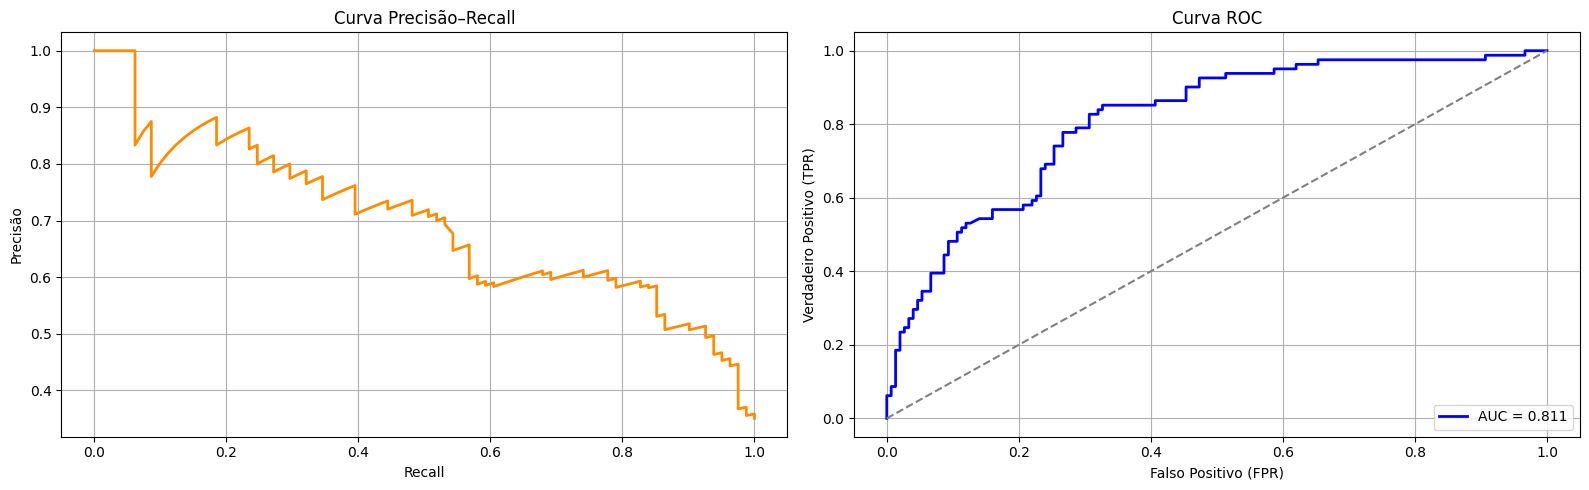


Avaliação do classificador: SVC(probability=True)
Acurácia:        0.749
Precisão:        0.677
Recall:          0.543
F1-Score:        0.603
Especificidade:  0.860
AUC:             0.815


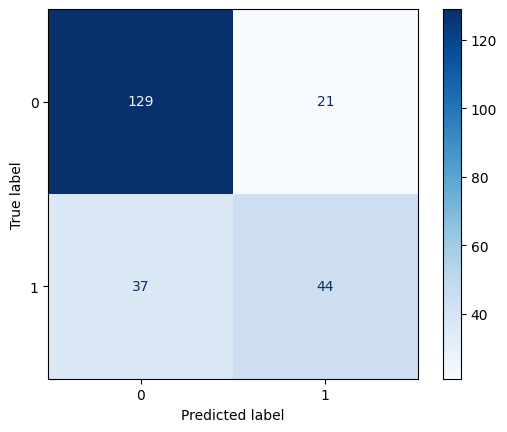

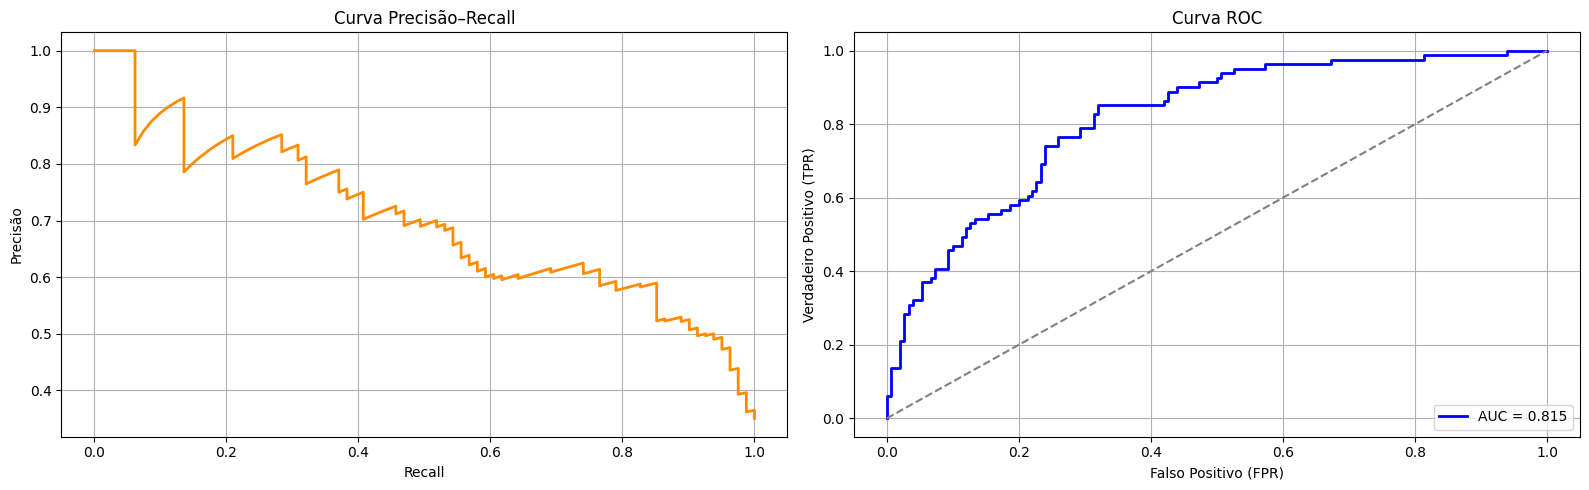

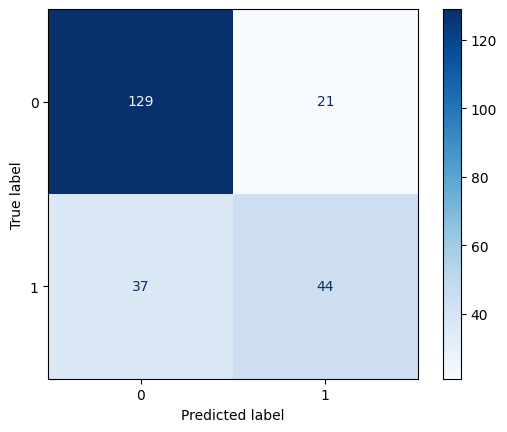

In [4]:

#X é 768 amostras por 8 features
print("Forma da matriz de X", X.shape)
print("Forma da matriz de Y", Yn.shape)
Grafico_IntervaloValores_Features()

media = np.mean(X, axis=0)
variancia = np.var(X, axis=0)
covariancia = np.cov(X)
# print("Média (np.mean):", media)
# print("Variância de X:", variancia)
# print("Covariancia de X:", covariancia)



Xn = Normaliza_Dados()
TreinarRandomForest(Xn, Y)
TreinarLogisticRegression(Xn, Y)
TreinarKNNVizinhos(Xn, Y)
TreinarSVM(Xn, Y)
XTrain, XTest, YTrain, YTest = SepararDadosTreinoTeste(Xn, Y, 0.3, 42)







# SKILEAR É QUE TRANS

----------------------------------------
Classificador: Random Forest
Acertos no teste: 75.32467532467533 %

Avaliação do classificador: RandomForestClassifier(random_state=42)
Acurácia:        0.753
Precisão:        0.688
Recall:          0.543
F1-Score:        0.607
Especificidade:  0.867
AUC:             0.820


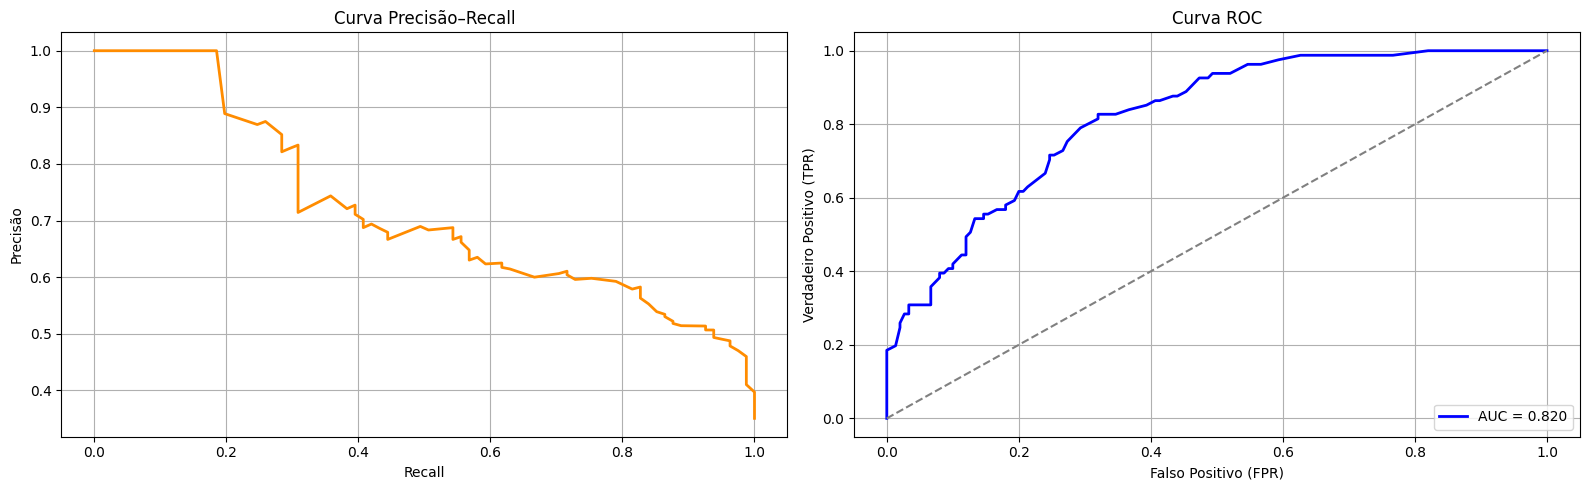


Avaliação do classificador: CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(random_state=42))
Acurácia:        0.753
Precisão:        0.688
Recall:          0.543
F1-Score:        0.607
Especificidade:  0.867
AUC:             0.826


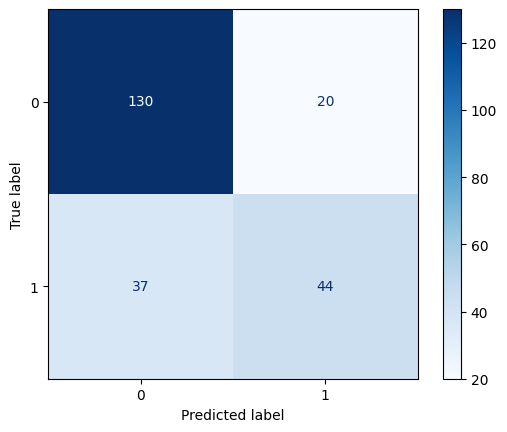

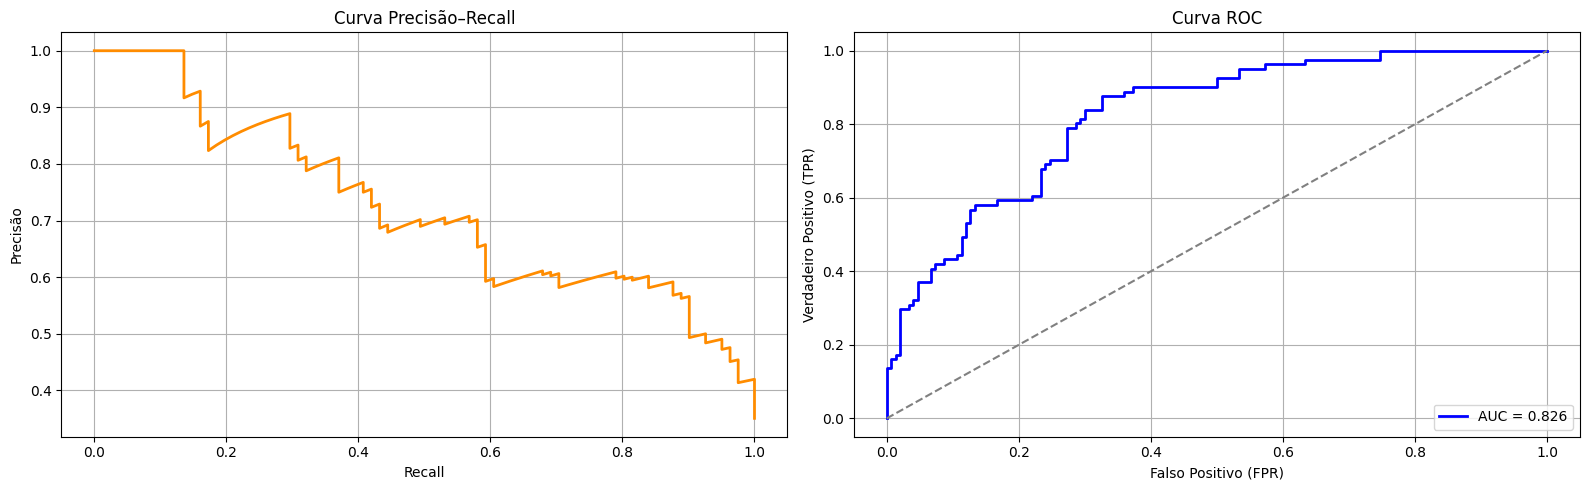

----------------------------------------
Classificador: Logistic Regression
Acertos no teste: 74.45887445887446 %

Avaliação do classificador: LogisticRegression(max_iter=10000)
Acurácia:        0.745
Precisão:        0.677
Recall:          0.519
F1-Score:        0.587
Especificidade:  0.867
AUC:             0.838


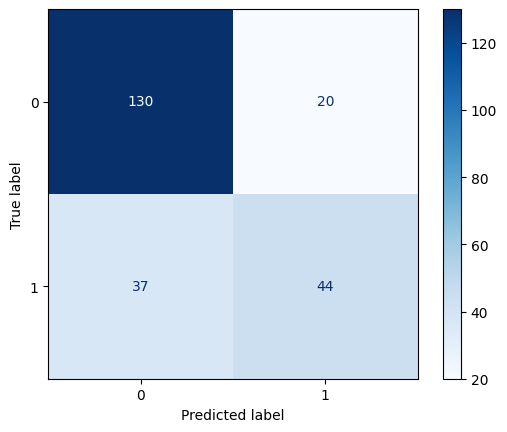

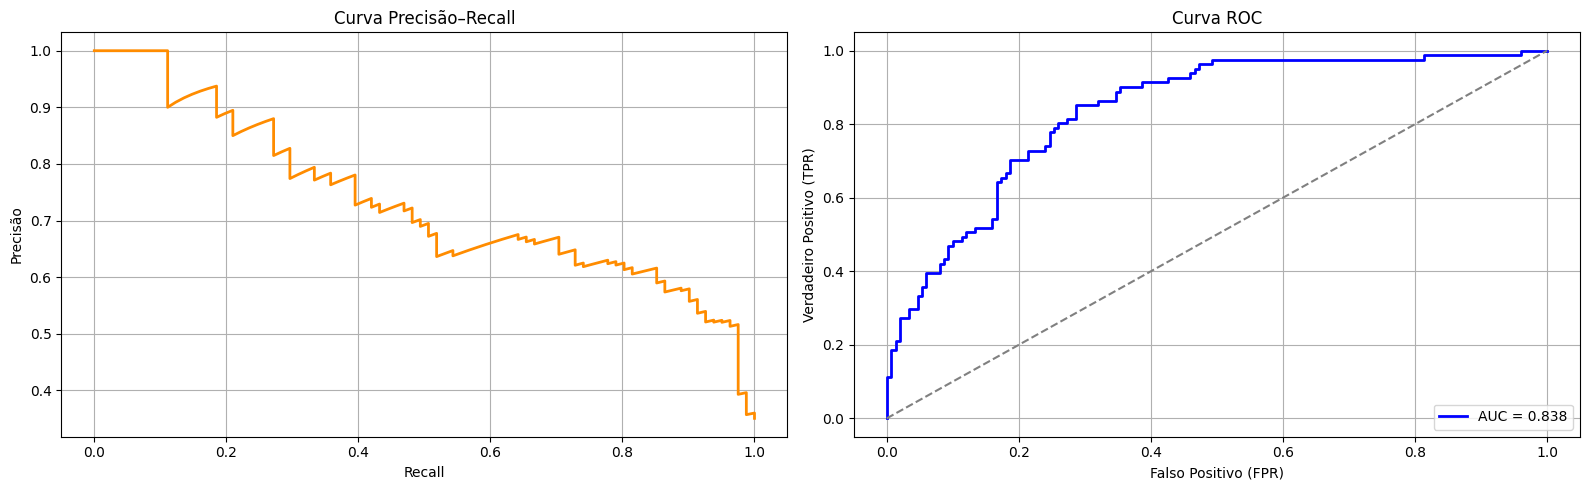


Avaliação do classificador: CalibratedClassifierCV(cv=5, estimator=LogisticRegression(max_iter=10000))
Acurácia:        0.745
Precisão:        0.677
Recall:          0.519
F1-Score:        0.587
Especificidade:  0.867
AUC:             0.837


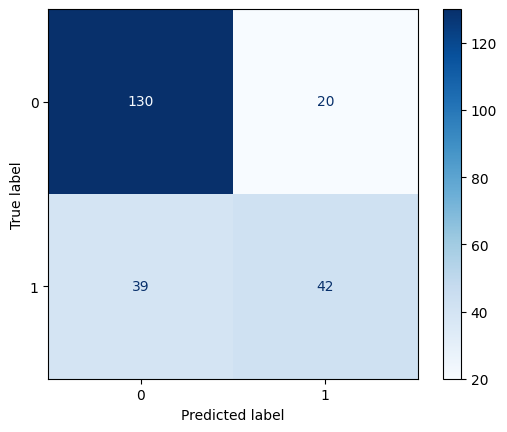

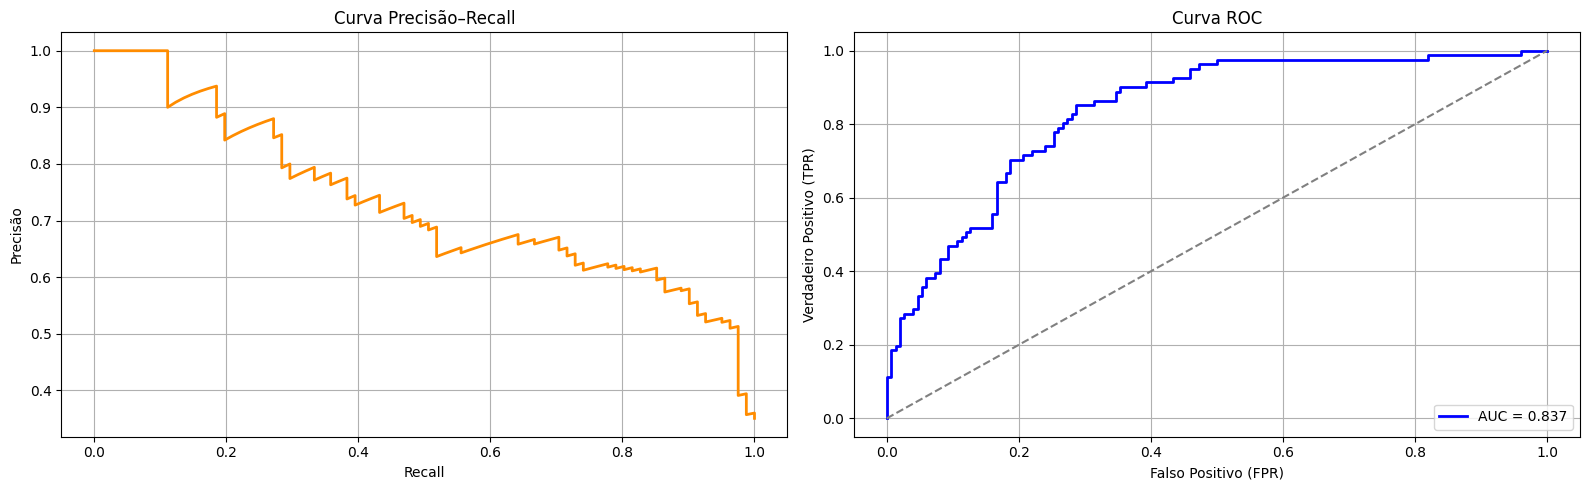

----------------------------------------
Classificador: KNN
Acertos no teste: 71.42857142857143 %

Avaliação do classificador: KNeighborsClassifier()
Acurácia:        0.714
Precisão:        0.615
Recall:          0.494
F1-Score:        0.548
Especificidade:  0.833
AUC:             0.757


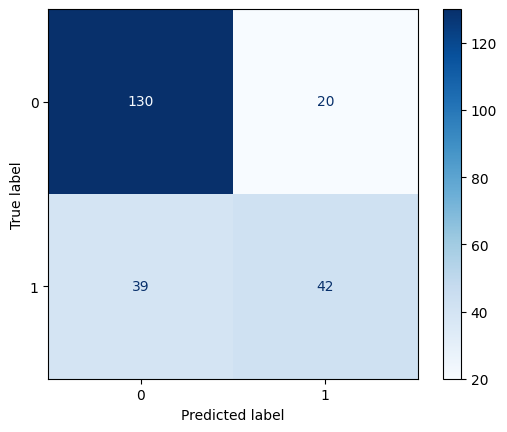

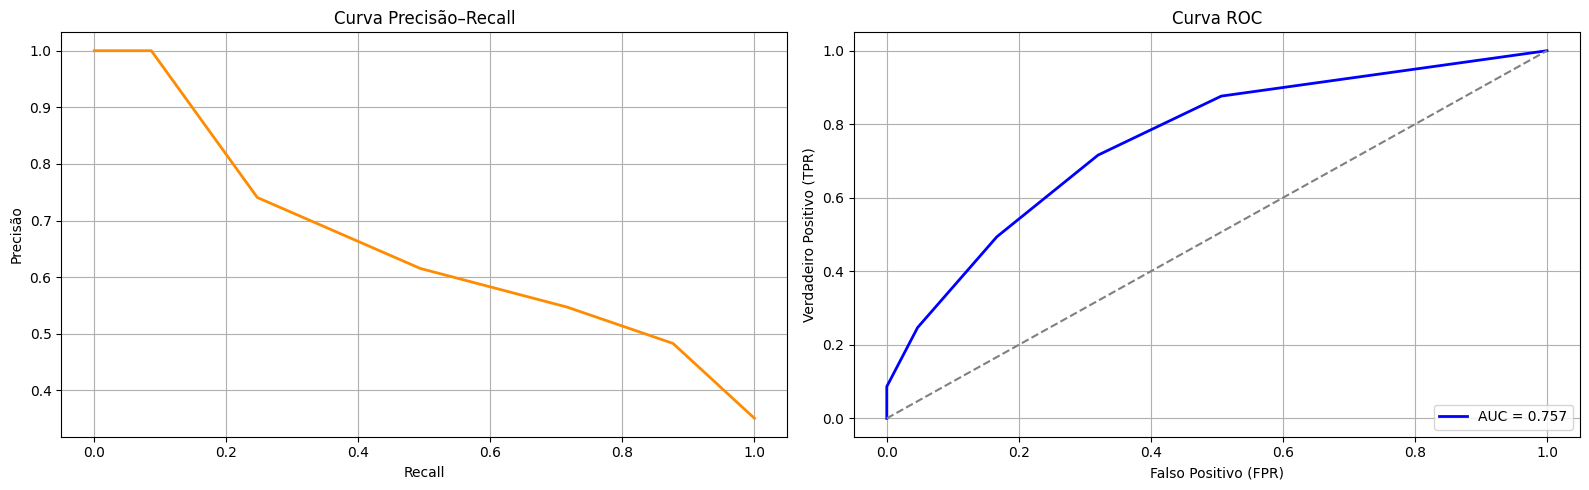


Avaliação do classificador: CalibratedClassifierCV(cv=5, estimator=KNeighborsClassifier())
Acurácia:        0.714
Precisão:        0.615
Recall:          0.494
F1-Score:        0.548
Especificidade:  0.833
AUC:             0.788


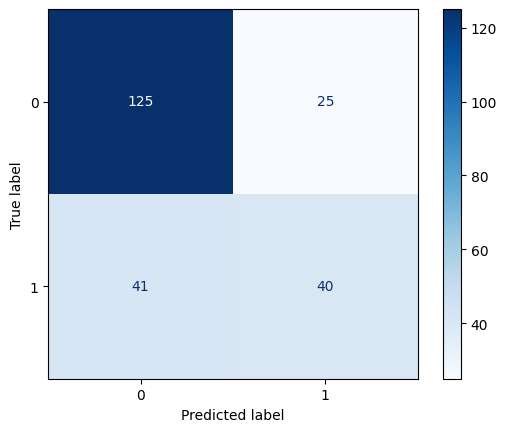

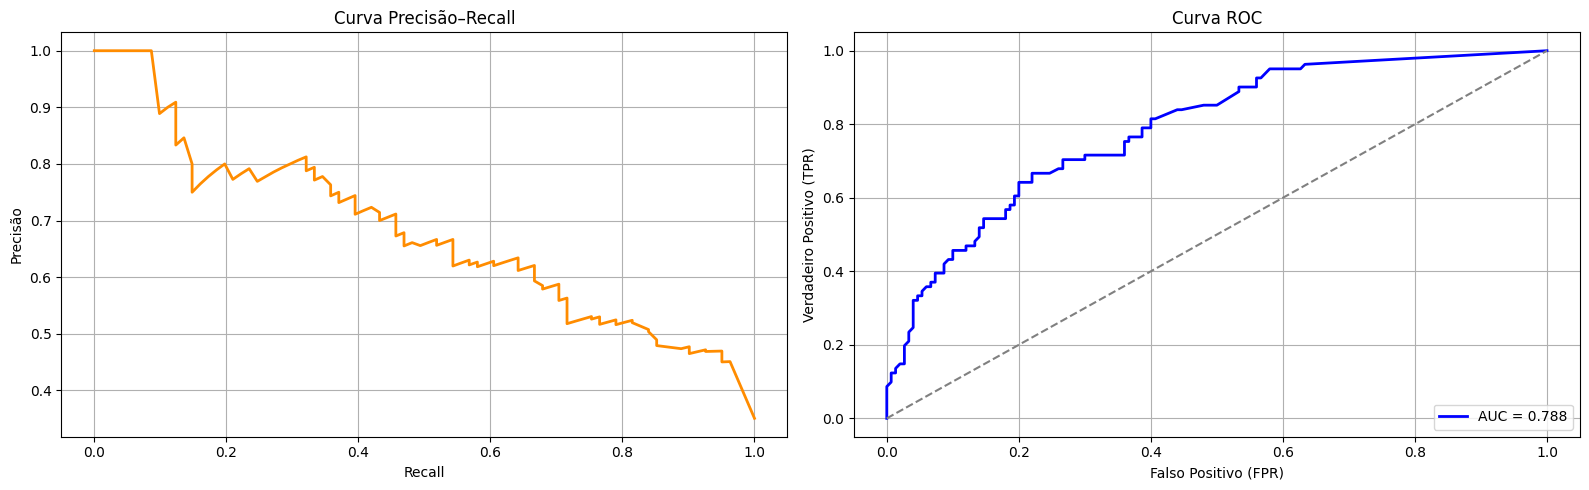

----------------------------------------
Classificador: SVM
Acertos no teste: 74.89177489177489 %

Avaliação do classificador: SVC(probability=True)
Acurácia:        0.749
Precisão:        0.677
Recall:          0.543
F1-Score:        0.603
Especificidade:  0.860
AUC:             0.811


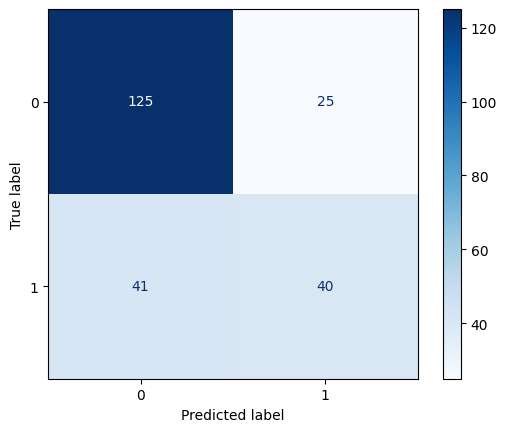

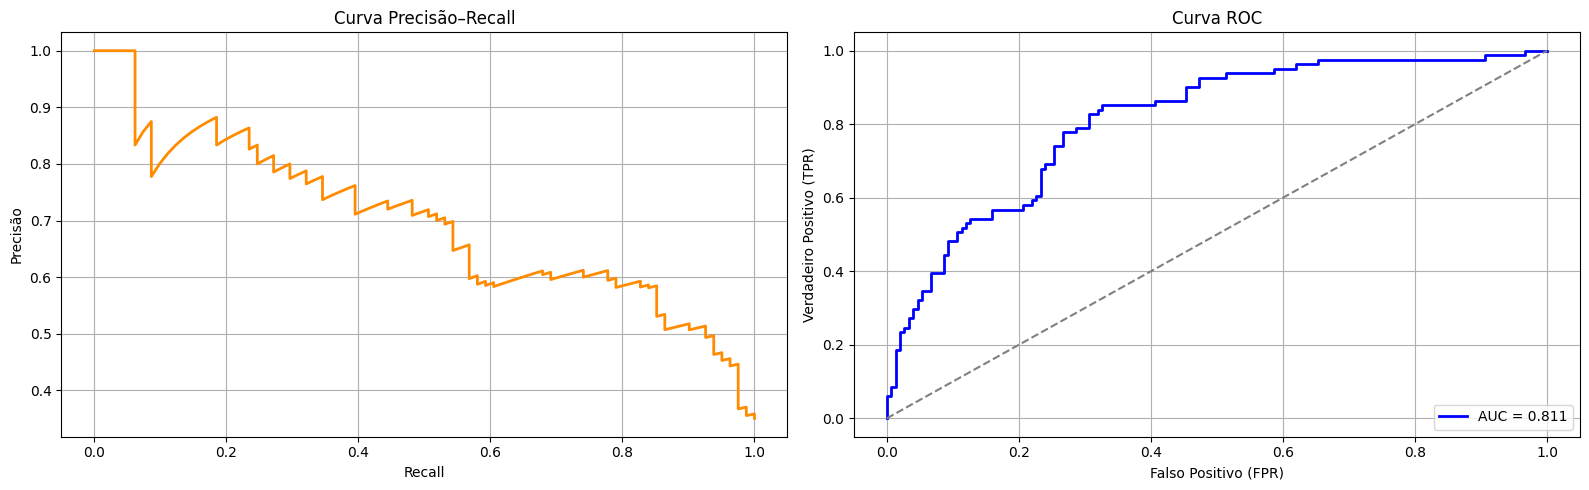


Avaliação do classificador: CalibratedClassifierCV(cv=5, estimator=SVC(probability=True))
Acurácia:        0.749
Precisão:        0.677
Recall:          0.543
F1-Score:        0.603
Especificidade:  0.860
AUC:             0.815


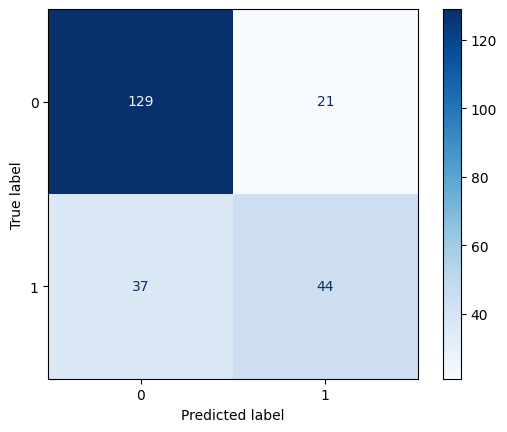

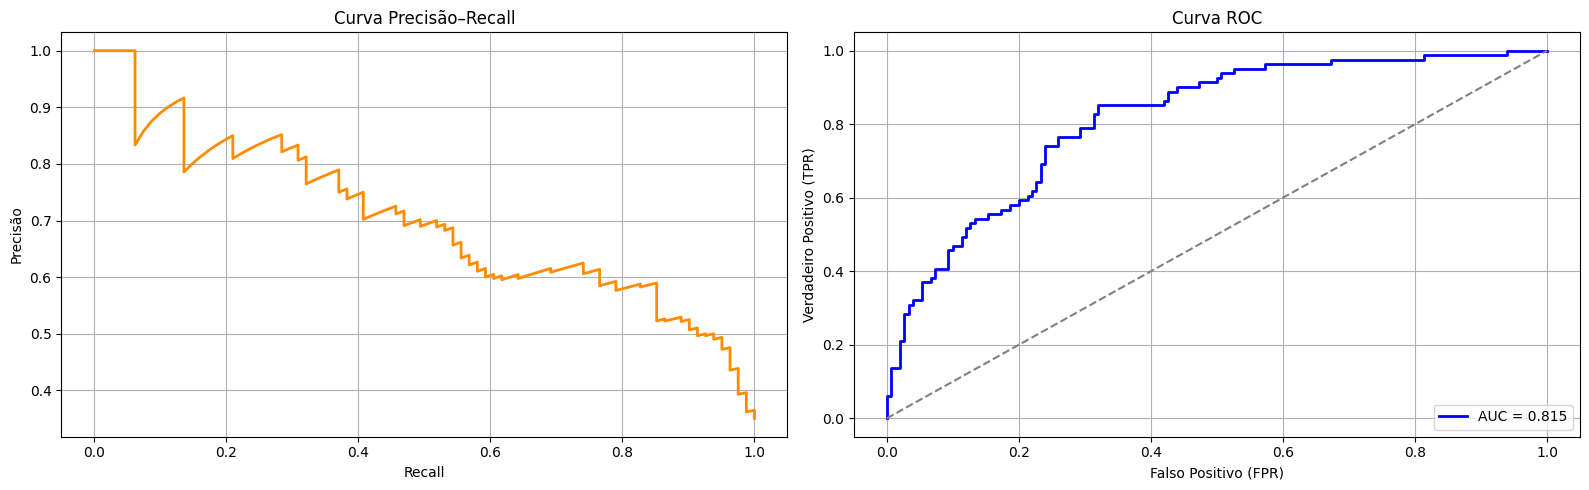

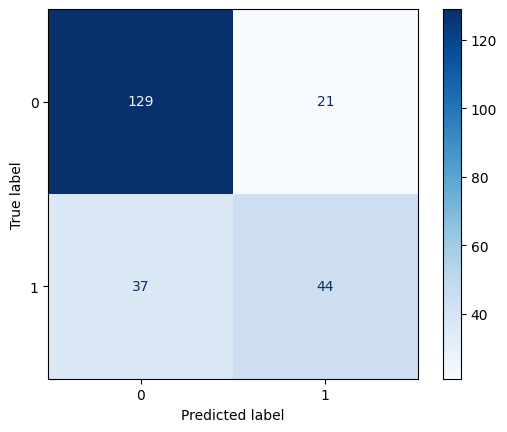

In [5]:
#METODO GERAL PARA TREINAR OS CLASSIFICADORES(CHAT GPT)
def TreinarEavaliar(modelo, nome, Xn, y):
    print("--" * 20)
    print(f"Classificador: {nome}")

    XTrain, XTest, YTrain, YTest = SepararDadosTreinoTeste(Xn, y, 0.3, 42)
    modelo.fit(XTrain, YTrain)
    YPred = modelo.predict(XTest)
    YProb = modelo.predict_proba(XTest)[:, 1]

    print("Acertos no teste:", modelo.score(XTest, YTest) * 100, "%")
    AvaliarClassificador(modelo, YTest, YPred, YProb)

    # Calibração
    modelo_cal = CalibrarModelo(XTrain, YTrain,modelo,  5)
    YProb_cal = modelo_cal.predict_proba(XTest)[:, 1]
    AvaliarClassificador(modelo_cal, YTest, YPred, YProb_cal)



TreinarEavaliar(RandomForestClassifier(random_state=42), "Random Forest", Xn, Y)
TreinarEavaliar(LogisticRegression(max_iter=10000), "Logistic Regression", Xn, Y)
TreinarEavaliar(KNeighborsClassifier(n_neighbors=5), "KNN", Xn, Y)
TreinarEavaliar(SVC(probability=True), "SVM", Xn, Y)
